In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.display.float_format = "{:,.4f}".format

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Helper functions from TA Review session and 2022 repo

def mvo_performance_stats(asset_returns,cov_matrix,port_weights, port_type,period):
    """ 
        Returns the Annualized Performance Stats for given asset returns, portfolio weights and covariance matrix
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
            port_weights = weights of the assets in the portfolio (1 x n) Vector
            port_type = Type of Portfolio | Eg - Tangency or Mean-Variance Portfolio
            period = Monthly frequency
    """
    
    ret = np.dot(port_weights,asset_returns)*period
    vol = np.sqrt(port_weights @ cov_matrix @ port_weights.T)*np.sqrt(period)
    sharpe = ret/vol

    stats = pd.DataFrame([[ret,vol,sharpe]],columns= ["Annualized Return","Annualized Volatility","Annualized Sharpe Ratio"], index = [port_type])
    return stats

def tangency_weights(asset_return,cov_matrix, cov_diagnolize = False):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector
        Inputs: 
            asset_return - return for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    if cov_diagnolize:
        asset_cov = np.diag(np.diag(cov_matrix))
    else:
        asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

# 2 Mean-Variance Optimization

In [3]:
df = pd.read_excel("../data/multi_asset_etf_data.xlsx", sheet_name="excess returns")
df.set_index("Date", inplace=True)

## 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
* Which assets have the best and worst Sharpe ratios? Recall that the Sharpe Ratio is simply the ratio of the mean-to-volatility of excess returns:
$$\text{sharpe ratio of investment }i = \frac{\mux_i}{\sigma_i}$$

In [4]:
def performance_stat(s: pd.Series) -> pd.Series:
    """
    Calculate the mean, volatility, sharpe of given series
    
    Parameters:
        s (pd.Series): 
            Excess return of certain asset / portfolio
            Index: all time period (i.e. monthly)
            
    Returns:
        s_stat: Series contains mean, volatility, sharpe of the input series
    """
    s_stat = s.agg(['mean', 'std']).T
    s_stat['mean'] *= 12
    s_stat['std'] *= (12 ** (1/2))
    s_stat['sharpe'] = s_stat['mean'] / s_stat['std']
    return s_stat

In [5]:
df_stat = df.apply(performance_stat).T
df_stat.sort_values('sharpe', inplace=True)
print(f"Best performer: {df_stat.index[-1]}; Worse performer: {df_stat.index[0]}")
df_stat

Best performer: SPY; Worse performer: BWX


,mean,std,sharpe
BWX,-0.0018,0.0834,-0.0221
DBC,0.0254,0.1790,0.1422
IEF,0.0143,0.0624,0.2287
EEM,0.0649,0.1965,0.3302
PSP,0.0799,0.2274,0.3516
QAI,0.0190,0.0508,0.3734
TIP,0.0223,0.0515,0.4332
EFA,0.0816,0.1660,0.4916
IYR,0.1295,0.1871,0.6920
HYG,0.0642,0.0892,0.7197


## 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

In [6]:
df_corr = df.corr()
df_corr_unstack = df_corr.unstack().sort_values()
df_corr_unstack = df_corr_unstack[df_corr_unstack < 1]
print(f"Highest correlation: {df_corr_unstack.index[-1]}; Lowest correlation: {df_corr_unstack.index[0]}")
df_corr

Highest correlation: ('PSP', 'SPY'); Lowest correlation: ('DBC', 'IEF')


,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
BWX,1.0000,0.3498,0.6476,0.6217,0.5577,0.4345,0.4535,0.5249,0.6680,0.4657,0.6171
DBC,0.3498,1.0000,0.5657,0.5819,0.4732,-0.3217,0.3183,0.4961,0.5479,0.5099,0.1367
EEM,0.6476,0.5657,1.0000,0.8516,0.7260,-0.1023,0.6218,0.7717,0.8072,0.7346,0.3027
EFA,0.6217,0.5819,0.8516,1.0000,0.7715,-0.1323,0.6979,0.8919,0.8537,0.8716,0.2875
HYG,0.5577,0.4732,0.7260,0.7715,1.0000,-0.0086,0.7576,0.8238,0.7688,0.7704,0.3659
IEF,0.4345,-0.3217,-0.1023,-0.1323,-0.0086,1.0000,0.0736,-0.1187,0.0557,-0.1557,0.7061
IYR,0.4535,0.3183,0.6218,0.6979,0.7576,0.0736,1.0000,0.7602,0.6560,0.7536,0.3972
PSP,0.5249,0.4961,0.7717,0.8919,0.8238,-0.1187,0.7602,1.0000,0.8383,0.8957,0.3209
QAI,0.6680,0.5479,0.8072,0.8537,0.7688,0.0557,0.6560,0.8383,1.0000,0.8410,0.4597
SPY,0.4657,0.5099,0.7346,0.8716,0.7704,-0.1557,0.7536,0.8957,0.8410,1.0000,0.2946


<Axes: >

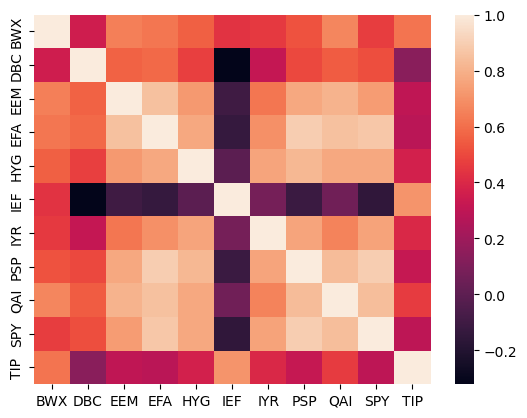

In [19]:
sns.heatmap(df_corr)

In [7]:
print("By table 1, TIP has higher mean return and sharpe ratio than IEF (domestic bonds) and BWX (foreign bonds).")

By table 1, TIP has higher mean return and sharpe ratio than IEF (domestic bonds) and BWX (foreign bonds).


## 3. The MV frontier.
* Compute and display the weights of the tangency portfolios: $\wtan$.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to
$\wtan$.

In [8]:
def mv_frontier_tang(df: pd.DataFrame, is_reg: bool = False) -> pd.Series:
    """
    Calculate the tangent portfolio weight on efficient frontier
    
    Parameters:
        df (pd.DataFrame): 
            Excess return df.
            Columns: all assets
            Index: all time period (i.e. monthly)
        is_reg (bool): 
            If True, use regularized covariance matrix.
            
    Returns:
        weight_tang: tangent portfolio weight in ascending order
    """
    df_cov_ann = df.cov()
    if is_reg:
        df_cov_ann += np.diag(np.diag(df_cov_ann))
        df_cov_ann /= 2
    df_cov_mean = pd.Series(np.linalg.inv(df_cov_ann) @ df.mean(), 
                            index=df_cov_ann.columns.to_list(),
                            name='Tangency Weight')
    df_tang = df_cov_mean / df_cov_mean.sum()
    df_tang.sort_values(inplace=True)
    return df_tang

In [9]:
weight_tang = mv_frontier_tang(df)
weight_tang

QAI   -3.1334
BWX   -1.4650
PSP   -1.2711
IYR   -0.2428
DBC    0.0284
EEM    0.2610
TIP    0.3569
EFA    0.4529
HYG    1.5289
IEF    1.8940
SPY    2.5900
Name: Tangency Weight, dtype: float64

In [10]:
print(f"The ranking of weight of tangency portfolio "
      f"{'=' if all(df_stat.index == weight_tang.index) else '!='} sharpe ratio rank.")

The ranking of weight of tangency portfolio != sharpe ratio rank.


In [11]:
df_tang = (df * weight_tang.loc[df.columns]).sum(axis=1)
df_tang_stat = performance_stat(df_tang)
df_tang_stat

mean     0.3702
std      0.1915
sharpe   1.9328
dtype: float64

## 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

In [12]:
# a) without TIPS
weight_tang_excl_tips = mv_frontier_tang(df.drop(columns=["TIP"]))
df_tang_excl_tips = (df * weight_tang_excl_tips.loc[df.drop(columns=["TIP"]).columns]).sum(axis=1)
performance_stat(df_tang_excl_tips)

mean     0.3863
std      0.2001
sharpe   1.9304
dtype: float64

In [13]:
# Change of tangent portfolio
weight_tang_excl_tips - weight_tang

BWX   -0.0478
DBC    0.0267
EEM    0.0171
EFA   -0.0114
HYG    0.0642
IEF    0.3185
IYR   -0.0031
PSP   -0.0430
QAI   -0.1055
SPY    0.1414
TIP       NaN
Name: Tangency Weight, dtype: float64

In [14]:
# a) TIPS += 0.0012
df_tip_adj = df.copy()
df_tip_adj["TIP"] += 0.0012
weight_tang_adj_tips = mv_frontier_tang(df_tip_adj)
df_tang_adj_tips = (df_tip_adj * weight_tang_adj_tips.loc[df_tip_adj.columns]).sum(axis=1)
performance_stat(df_tang_adj_tips)

mean     0.3289
std      0.1619
sharpe   2.0310
dtype: float64

In [15]:
# Change of tangent portfolio
weight_tang_adj_tips - weight_tang

BWX    0.2021
DBC   -0.1130
EEM   -0.0722
EFA    0.0483
HYG   -0.2716
IEF   -1.3472
IYR    0.0132
PSP    0.1821
QAI    0.4464
SPY   -0.5980
TIP    1.5100
Name: Tangency Weight, dtype: float64

In [16]:
print("""
Based on the results, TIPS should be not considered as a separate assets
1. sharpe ratio of tangent portfolio with/without TIPS is almost the same (with-TIPS has marginal advantage);
2. when TIPS increase overall, tangent portfolio has a higher sharpe
""")


Based on the results, TIPS should be not considered as a separate assets
1. sharpe ratio of tangent portfolio with/without TIPS is almost the same (with-TIPS has marginal advantage);
2. when TIPS increase overall, tangent portfolio has a higher sharpe



# 3. Allocations

In [17]:
target_return = 0.01
excess_return_mean = df.mean()

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is,
$$\wEW_i = \frac{1}{n}$$

In [20]:
equalWt = np.array(len(df_corr.index) * [1/len(df_corr.index)])
eql_rescale_factor = target_return/(equalWt.T @ excess_return_mean)

equalWt_port_stats = mvo_performance_stats(excess_return_mean, df.cov(),(equalWt * eql_rescale_factor),'Equal Weight Portfolio',12)
equalWt_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Equal Weight Portfolio,0.1200,0.2133,0.5627


#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,
$$\wRP_i = \frac{1}{\sigma_i^2}$$

In [21]:
rp_wt = np.array(1/df_stat['std'])
rp_rescale_factor = target_return/ (rp_wt.T @ excess_return_mean)

risk_parity_stats = mvo_performance_stats(excess_return_mean,df.cov(),(rp_wt * rp_rescale_factor),'Risk Parity Portfolio',12)
risk_parity_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Risk Parity Portfolio,0.1200,0.1970,0.6091


#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 
$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$
but this time, use a regularized covariance matrix,
$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$
where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 

In [32]:
asset_var = df.var()
reg_cov_matrix = (df.cov() + np.diag(asset_var))/2
reg_wt = np.linalg.inv(reg_cov_matrix).dot(np.array(excess_return_mean))
unscaled_regularized_stats = mvo_performance_stats(excess_return_mean, df.cov(),(reg_wt),'Regularized Portfolio',12)
unscaled_return = np.array(unscaled_regularized_stats['Annualized Return'])
reg_rescale = (target_return/unscaled_return[0])*12

regularized_stats = mvo_performance_stats(excess_return_mean, df.cov(),(reg_wt*reg_rescale),'Regularized Portfolio',12)
regularized_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Regularized Portfolio,0.1200,0.0941,1.2753


In [33]:
risk_parity_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Risk Parity Portfolio,0.1200,0.1970,0.6091


In [34]:
equalWt_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Equal Weight Portfolio,0.1200,0.2133,0.5627


For each of these portfolios the Annualized Return is the same because they were made with target return conditioning. The volatility of the regularized portfolio has less than half of the volatility of the risk parity and equal weight portfolios. Extending on this the Annualized Sharpe Ratio is roughly double that of the risk parity and equal weight portfolios. Between the risk parity and equal weight portfolios the risk parity portfolio has a slightly higher annualized sharpe ratio.

### Comparing

In order to compare all these allocation methods, (those above, along with the tangency portfolio obtained in the previous section,) rescale each weight vector, such that it has targeted mean return of $\mutarg$.

* Calculate the performance of each of these portfolios over the sample.
* Report their mean, volatility, and Sharpe ratio. 
* How do these compare across the four allocation methods?